<h1><center>COMP1008: Exercise 4<br/>
Classification: Decision Trees and Neural Networks</center></h1>

We will be applying decision trees and neural networks to classify cancelled bookings with a real-world hotel booking dataset. Real-world data is imperfect. We will need to use some of the preprocessing techniques as well as some more advanced techniques.

This notebook contains the last tutorials of two computing sessions in two weeks.

## 1. Tutorial: Exploration and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data-hotel_bookings.csv')
df.head()

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_quarter,booked_with_agent,is_canceled
0,Resort Hotel,7,0,1,1,0.0,Direct,0,0,0,NaN,75.0,0,0,Q3,0,0
1,Resort Hotel,13,0,1,1,0.0,Corporate,0,0,0,Transient,75.0,0,0,Q3,1,0
2,Resort Hotel,14,0,2,2,0.0,TA/TO,0,0,0,Transient,98.0,0,1,Q3,1,0
3,Resort Hotel,14,0,2,2,0.0,TA/TO,0,0,0,Transient,98.0,0,1,Q3,1,0
4,Resort Hotel,0,0,2,2,0.0,Direct,0,0,0,Transient,107.0,0,0,Q3,0,0


In [3]:
df.shape

(118673, 17)

We can see that this is a binary classification problem. Based on the 16 features (input) of the booking, the task is to predict if a booking will be cancelled (output label). The value in the label column `is_canceled` is 1 if the booking was cancelled; 0 otherwise. The output labels are discrete / categorical, so this is a classification task. There are over 118k samples. The 16 input features are of a mix of numerical and categorical values. This will require preprocessing!

### 1.1. Data Exploration 

We need some data analysis to check what preprocessing is needed to prepare the data suitable for the classification models.

In [4]:
df.isnull().sum()

hotel                                 0
lead_time                             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
customer_type                     10678
adr                                5933
required_car_parking_spaces           0
total_of_special_requests             0
arrival_quarter                       0
booked_with_agent                     0
is_canceled                           0
dtype: int64

We can observe: there are missing values for three input features `customer_type`, `children` and `adr`. If we send these to some machine learning models this would lead to errors. We'll need to preprocess these.

We could quickly observe the rough distributions of and correlations between some of the numercial features in one plot using the Pandas method `scatter_matrix`.

array([[<Axes: xlabel='lead_time', ylabel='lead_time'>,
        <Axes: xlabel='adr', ylabel='lead_time'>,
        <Axes: xlabel='children', ylabel='lead_time'>],
       [<Axes: xlabel='lead_time', ylabel='adr'>,
        <Axes: xlabel='adr', ylabel='adr'>,
        <Axes: xlabel='children', ylabel='adr'>],
       [<Axes: xlabel='lead_time', ylabel='children'>,
        <Axes: xlabel='adr', ylabel='children'>,
        <Axes: xlabel='children', ylabel='children'>]], dtype=object)

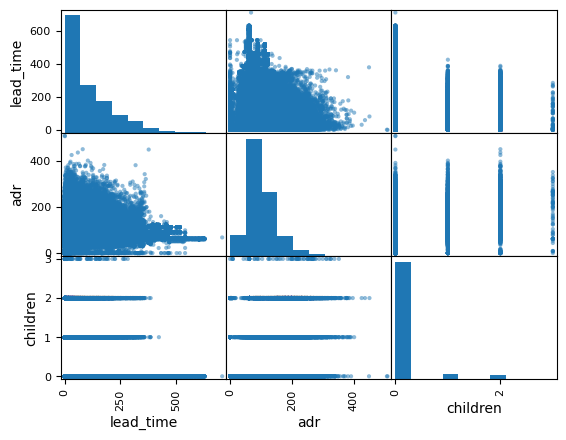

In [52]:
pd.plotting.scatter_matrix(df[['lead_time','adr','children']])

We can observe: From the plots column `children` seems to have an outlier or error. In either case this should be fixed as it brings noises to the data and does not help with building a reliable model.

In [6]:
df['children'].max()

10.0

<Axes: >

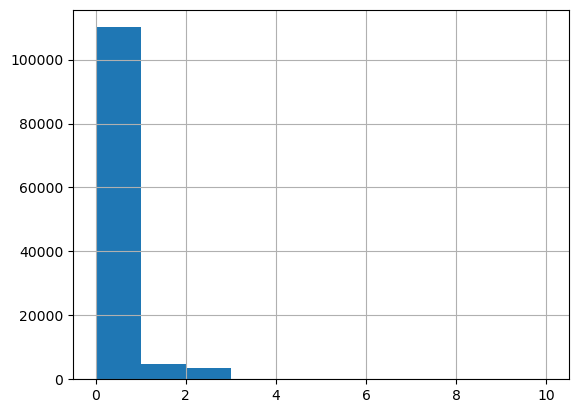

In [7]:
df['children'].hist() # values of `children` also skewed to the left, most frequent value is 0

In [8]:
df.describe() # by default displays stats of all numerical features

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,adr,required_car_parking_spaces,total_of_special_requests,booked_with_agent,is_canceled
count,118673.000000,118673.000000,118673.000000,118673.000000,118669.000000,118673.000000,118673.000000,118673.000000,112740.000000,118673.000000,118673.000000,118673.000000,118673.000000
mean,104.466307,0.933169,2.515349,1.858283,0.104105,0.029527,0.087577,0.137142,102.379482,0.062752,0.571807,0.864198,0.372351
std,106.906345,0.998976,1.904086,0.577958,0.398956,0.169278,0.846803,1.500239,47.622370,0.245728,0.793189,0.342579,0.483433
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,1.000000,0.000000
50%,70.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,1.000000,0.000000
75%,161.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,1.000000,1.000000
max,709.000000,19.000000,50.000000,55.000000,10.000000,1.000000,26.000000,72.000000,510.000000,8.000000,5.000000,1.000000,1.000000


We can observe: the ranges (`min` and `max`) of some of the numerical features (e.g. `adr` and `is_repeated_guest`) are much larger than that of the others. This may cause problems for some machine learning models that are sensitive to feature scaling, so we should preprocess this.

In [9]:
df.describe(include = 'object') # with parameter 'include='object', displays stats of all categorical features

,hotel,distribution_channel,customer_type,arrival_quarter
count,118673,118673,107995,118673
unique,2,5,4,4
top,City Hotel,TA/TO,Transient,Q3
freq,78998,97403,80975,36912


We can observe: There are 4 categorical features. Feature `customer_type` has some missing data (indicated by the `count` row). The `unique` row shows the number of unique categories for these features. We can see that there are only two hotels. The `top` and `freq` rows show the most appeared category and its frequency. There are much more samples for `City Hotel`, so the samples of `hotel` are not balanced.

`DecisionTreeClassifier` and `MLPClassifier` require numerical features. We need to preprocess these categorical features into an appropriate format. 

<div class="alert alert-info">
    <h3>Task 1</h3>
</div>

<b>Question</b>: How many bookings % have been cancelled at these hotels?<br>
<b>Answer</b>: We can observe: City Hotel or (Resort Hotel) has more cancellations, i.e. x%.

In [45]:
# hint: use condition in df[A==B] to find the samples of the hotel
# Then compare the number of rows in the dataframes by using the len() method

canceled = df[df["is_canceled"] == 1]
c_city = canceled[canceled["hotel"] == "City Hotel"]
c_resort = canceled[canceled["hotel"] == "Resort Hotel"]

print("Percentage of bookings canceled = ", ((len(canceled) / len(df)) * 100), "%\n")
print("Percentage of cancelations which were City Hotel = ", ((len(c_city) / len(canceled))*100), "%\n")
print("Percentage of cancelations which were Resort Hotel = ",((len(c_resort) / len(canceled))*100), "%\n")

Percentage of bookings canceled =  37.23509138557212 %

Percentage of cancelations which were City Hotel =  74.85742735584321 %

Percentage of cancelations which were Resort Hotel =  25.142572644156786 %



### 1.2. Data Preprocessing

#### Missing values

We need to process the above identified three different features with missing values using appropriate methods.

There are a lot of missing values in the categorical feature `customer_type`. Removing them all may lose important information. Replacing them with the mean or median is not applicable. We can instead replace these with `mode`, i.e. the most frequently occuring value in this feature, as follows.

In [46]:
# .mode() returns a Series not a single value. value of index 0 [0] is the most frequent
customer_mode = df['customer_type'].mode()[0]
df['customer_type'] = df['customer_type'].fillna(customer_mode) # fillna(x) method replaces missing values with x

`adr` is numerical but discrete, identified as skewed in the above analysis - most values in [50,100]. For discrete data, we can also use the `mode` method. The same applies to the `children` feature.

In [47]:
adr_mode = df['adr'].mode()[0]
df['adr'] = df['adr'].fillna(adr_mode)

In [48]:
children_mode = df['children'].mode()[0]
df['children'] = df['children'].fillna(children_mode)

In [49]:
# Sanity check if all missing values have been replaced
df.isnull().sum()

hotel                             0
lead_time                         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
arrival_quarter                   0
booked_with_agent                 0
is_canceled                       0
dtype: int64

<b>Question</b>: For features of skewed continious values, using the median value to replace missing values is generally better than using the mean. Why?

When we take the mean of skewed data, this wouuld take into account the lower values which are not "skewed", therefore giving us a value that would be lower than expected or higher than expected, the median value on the other hand, would give us a quote on quote mean of the majority of the data samples which are in this case skewed

#### Outliers

To fix the outlier in feature `children`, we could first locate its index using a condition. Then replace it with the most frequent value.

In [50]:
d = df['children']
ind = d[d == d.max()].index
ind

Index([322], dtype='int64')

In [51]:
df.loc[ind[0],'children'] = children_mode

#### Handling categorical features

For machine learning models, categorical features need to be transformed into numerical features, without losing their meaning. There are different techniques for this. The **one-hot encoding** technique is appropriate for dataset of small number of categories.

<img align="right" width=550, src="onehotencoding.PNG">

For each categorical feature, one-hot encoding creates <i>n</i> new binary columns for the <i>n</i> categorical values. For each sample, a value 1 is set in the column of the original category, and 0 for the columns of the other values. The original column is removed as it is now redundant. 

For example, for the three categorical values `Toyota`, `Ford` and `Volvo` in feature `car_make`, three new columns are added as shown on the right. Sample ID=1 is `Toyota`, so 1 is placed in the `Toyota` column and 0s for the other two columns.

Pandas provides the `get_dummies()` method to convert categorical features into 'dummy features' using one-hot encoding. After applying this, you can see as below that all the categorical columns are replaced by new dummy features in the new dataframe (now of 28 columns).

In [53]:
df = pd.get_dummies(df)
df.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,adr,required_car_parking_spaces,...,distribution_channel_TA/TO,distribution_channel_Undefined,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_quarter_Q1,arrival_quarter_Q2,arrival_quarter_Q3,arrival_quarter_Q4
0,7,0,1,1,0.0,0,0,0,75.0,0,...,False,False,False,False,True,False,False,False,True,False
1,13,0,1,1,0.0,0,0,0,75.0,0,...,False,False,False,False,True,False,False,False,True,False
2,14,0,2,2,0.0,0,0,0,98.0,0,...,True,False,False,False,True,False,False,False,True,False
3,14,0,2,2,0.0,0,0,0,98.0,0,...,True,False,False,False,True,False,False,False,True,False
4,0,0,2,2,0.0,0,0,0,107.0,0,...,False,False,False,False,True,False,False,False,True,False


#### Feature scaling

Now let's use the `MinMaxScaler` method to scale the features into the same range.

In [54]:
from sklearn.preprocessing import MinMaxScaler

In [55]:
norm = MinMaxScaler().fit(df) # calculates the minimum and maximum values of the data
arr = norm.transform(df) # transform/scale the data using the scaler to [0,1]
df = pd.DataFrame(arr, columns=df.columns) # create a dataframe from the scaled NumPy array
df.describe()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,adr,required_car_parking_spaces,...,distribution_channel_TA/TO,distribution_channel_Undefined,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_quarter_Q1,arrival_quarter_Q2,arrival_quarter_Q3,arrival_quarter_Q4
count,118673.000000,118673.000000,118673.000000,118673.000000,118673.000000,118673.000000,118673.000000,118673.000000,118673.000000,118673.000000,...,118673.000000,118673.000000,118673.000000,118673.000000,118673.000000,118673.000000,118673.000000,118673.000000,118673.000000,118673.000000
mean,0.147343,0.049114,0.050307,0.033787,0.034672,0.029527,0.003368,0.001905,0.196786,0.007844,...,0.820768,0.000042,0.030849,0.004281,0.772316,0.192554,0.198942,0.283637,0.311040,0.206382
std,0.150785,0.052578,0.038082,0.010508,0.132638,0.169278,0.032569,0.020837,0.092634,0.030716,...,0.383548,0.006491,0.172910,0.065287,0.419340,0.394308,0.399206,0.450764,0.462921,0.404710
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.025388,0.000000,0.020000,0.036364,0.000000,0.000000,0.000000,0.000000,0.127451,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.098731,0.052632,0.040000,0.036364,0.000000,0.000000,0.000000,0.000000,0.178431,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.227080,0.105263,0.060000,0.036364,0.000000,0.000000,0.000000,0.000000,0.243137,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Our data is now ready!

<a id='s2_tutorial'></a>
## 2. Tutorial: Decision Trees and Neural Networks 

The remainder of this tutorial will work with the Resort Hotel data. You can try to build your machine learning models for the City Hotel.

In [56]:
resort_df = df[df['hotel_Resort Hotel'] == 1] # create an entirely new dataframe object
resort_df = resort_df.drop(['hotel_Resort Hotel','hotel_City Hotel'],axis=1) # redundant columns are removed
resort_df.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,adr,required_car_parking_spaces,...,distribution_channel_TA/TO,distribution_channel_Undefined,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_quarter_Q1,arrival_quarter_Q2,arrival_quarter_Q3,arrival_quarter_Q4
0,0.009873,0.0,0.02,0.018182,0.0,0.0,0.0,0.0,0.147059,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.018336,0.0,0.02,0.018182,0.0,0.0,0.0,0.0,0.147059,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.019746,0.0,0.04,0.036364,0.0,0.0,0.0,0.0,0.192157,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.019746,0.0,0.04,0.036364,0.0,0.0,0.0,0.0,0.192157,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.000000,0.0,0.04,0.036364,0.0,0.0,0.0,0.0,0.209804,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [57]:
# import all required libraries from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

### 2.1 Split the data into training and test sets

In [58]:
# prepare the training and testing datasets
y = resort_df['is_canceled'] # the class labels
X = resort_df.drop('is_canceled',axis=1) # the input features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1) # 70:30 split ratio

**Note:** Some `scikit-learn` methods use randomness, e.g. `train_test_split()` shuffles the data before the split. Running the same code multiple times will result in <b>different results</b>.

It is strongly recommended that you set the `random_state` parameter in your coursework with a 'seed' for the underlying random number generator; otherwise you may generate different results to what you have just written an analysis about! Your results are also reproducible for someone else. Reproduciblity is an important aspect of reporting scientific results.

### 2.2 Decision Trees

## **Train a decision tree on the data**

The *hyperparameter* `max_depth` in `DecisionTreeClassifier` limits the levels of the tree. For other hyperparameters, see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [59]:
# generate a new decision tree model
t_model = DecisionTreeClassifier(max_depth=4,random_state=1) # decision tree implementation uses randomness too!
# fit() trains our decision tree on the training data using the known true labels (i.e. supervised learning).
t_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, random_state=1)

**Evaluate the decision tree's performance**

In [60]:
y_predict = t_model.predict(X_test) # predict() uses our trained tree to predict labels for the test data
# compare the true labels (y_test) to the predicted labels (y_predict)
print('Testing accuracy: \t', metrics.accuracy_score(y_test, y_predict))

Testing accuracy: 	 0.7421658405444006


The accuracy is a single number, around 74%. A <b>confusion matrix</b> provides more information on how well the model performs on the different classes, with four breakdown results as shown on the right. 'Positives' refers to the positive class, i.e. label `is_canceled`=1. 'Negatives' refers to the negative class, i.e. label is 0. 'True' and 'False' indicates correct and wrong classifications, respectively:

<img align="right" width=400, src="confusion_matrix.JPG">

+ <b>True Negatives (TN)</b>: The number of samples where their actual and predicted labels are both 0, i.e. of all the not cancelled bookings, how many the model <i>correctly</i> predicts as not cancelled.
+ <b>True Positives (TP)</b>: The number of samples where their actual and predicted labels are both 1, i.e. of all the cancelled bookings, how many the model <i>correctly</i> predicts as cancelled.
+ <b>False Negatives (FN)</b>: The number of samples where their actual label is 1, but their predicted label was 0, i.e. of all the cancelled bookings, how many the model <i>incorrectly</i> predicts wouldn't be cancelled.
+ <b>False Positives (FP)</b>: The number of samples where their actual label is 0, but their predicted label was 1, i.e. of all the not cancelled bookings, how many the model <i>incorrectly</i> predicts as cancelled.

We would want the values of TP and TN, i.e. correct predictions, as high as possible.

In [61]:
cm = metrics.confusion_matrix(y_test,y_predict)
cm

array([[8563,   17],
       [3052,  271]])

The below python function `cf_matrix()` can display the confusion matrix in a more readable format.

In [62]:
# Plot the Confusion Matrix
def cf_matrix(mat, t_name, model_name):
    
    fig, ax = plt.subplots()
    im = ax.imshow(mat)
    
    ax.set_xticks(range(0,len(t_name)))
    ax.set_yticks(range(0,len(t_name)))
    ax.set_xticklabels(t_name)
    ax.set_yticklabels(t_name)

    for i in range(0,len(t_name)):
        for j in range(0,len(t_name)):
            text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k")
    
    plt.ylabel('actual label')
    plt.xlabel('predicted label')
    plt.title("Confusion Matrix for {model_name}")

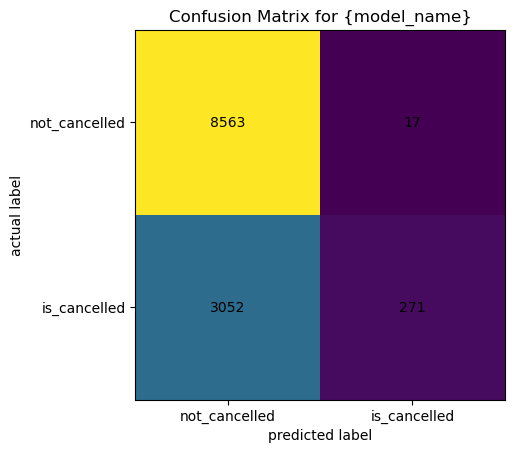

In [63]:
cf_matrix(cm,['not_cancelled','is_cancelled'],'DecisionTreeClassifier')

We can observe: the model does very well classifying bookings that are not cancelled - only 17 out of (8563+17) samples are misclassified. This is an accuracy of 8563 / (8563+17) = 99.8%!

However, it does not do so well at classifying the cancelled bookings - only 271 of (3052+271) were correctly classified! The accuracy of classifying cancelled bookings is actually only 271 / (3052+271) = 8%!

<b>Question</b>: So the overall performance of 74% accuracy was mainly contributed by the correct classifications on not cancelled bookings. Why is this performance?

Hint: Recall the above data exploration where we observe the % of cancellations at Resort Hotel. Are the labels balanced? The model can learn more from more samples. Or, it could be that we haven't used suitable hyperparameters.

The resort hotel doesn't have a lot of cancelations, the decision tree might take this into account and incorrectly  predict the the bookings are not going to be cancelled, this could also be due to poor distribution of the training and testing data


**Visualising and interpreting the decision tree**

Decision trees are easy to visualise and interpret with the `plot_tree` method.

[Text(0.5625, 0.9, 'lead_time <= 0.02\ngini = 0.404\nsamples = 27772\nvalue = [19985, 7787]\nclass = Not Cancelled'),
 Text(0.3125, 0.7, 'required_car_parking_spaces <= 0.062\ngini = 0.163\nsamples = 7846\nvalue = [7144, 702]\nclass = Not Cancelled'),
 Text(0.25, 0.5, 'lead_time <= 0.011\ngini = 0.204\nsamples = 6102\nvalue = [5400, 702]\nclass = Not Cancelled'),
 Text(0.125, 0.3, 'lead_time <= 0.002\ngini = 0.156\nsamples = 4751\nvalue = [4346, 405]\nclass = Not Cancelled'),
 Text(0.0625, 0.1, 'gini = 0.119\nsamples = 2541\nvalue = [2380, 161]\nclass = Not Cancelled'),
 Text(0.1875, 0.1, 'gini = 0.196\nsamples = 2210\nvalue = [1966, 244]\nclass = Not Cancelled'),
 Text(0.375, 0.3, 'previous_cancellations <= 0.019\ngini = 0.343\nsamples = 1351\nvalue = [1054, 297]\nclass = Not Cancelled'),
 Text(0.3125, 0.1, 'gini = 0.325\nsamples = 1314\nvalue = [1046, 268]\nclass = Not Cancelled'),
 Text(0.4375, 0.1, 'gini = 0.339\nsamples = 37\nvalue = [8, 29]\nclass = Cancelled'),
 Text(0.375, 0.5,

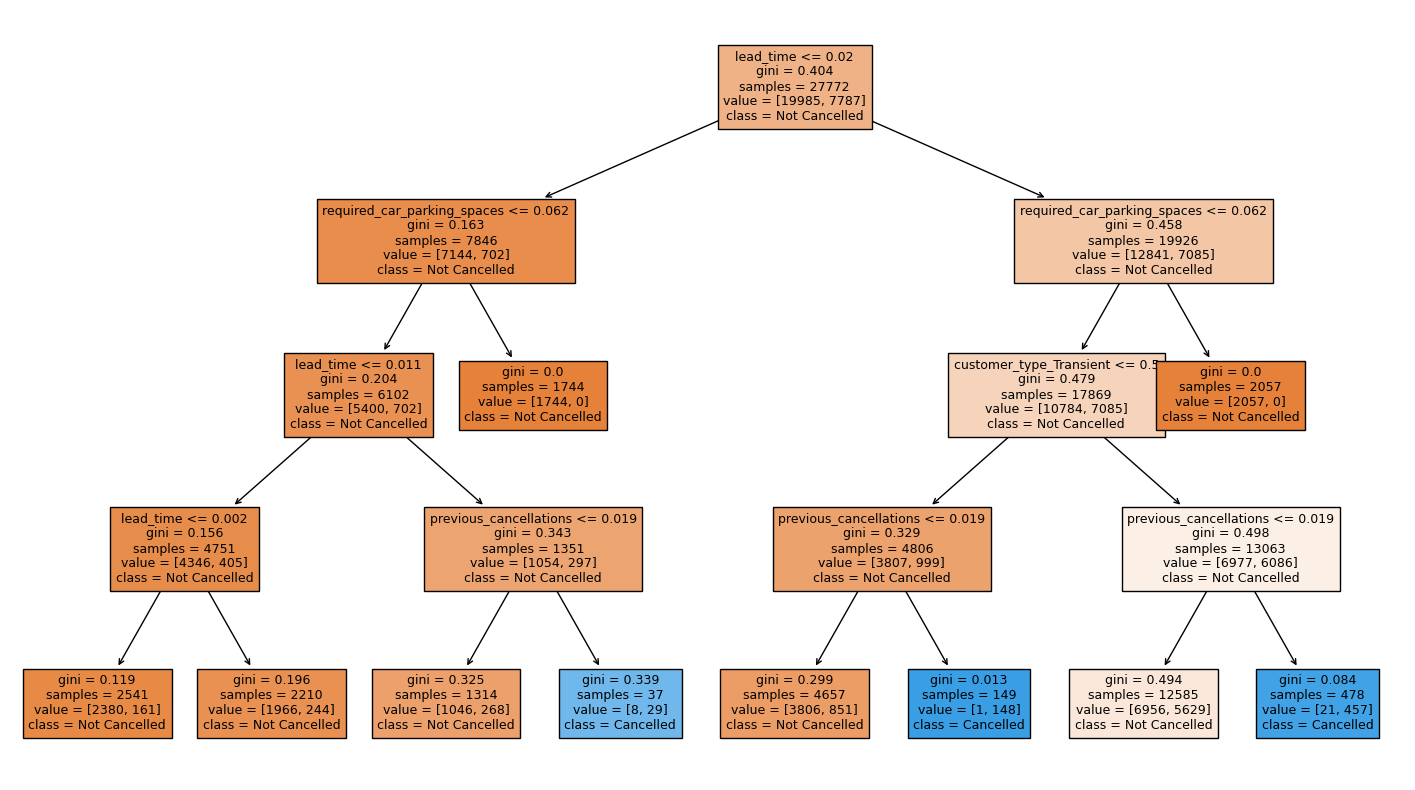

In [64]:
hotel_features = list(X_train.columns)
hotel_class = ['Not Cancelled','Cancelled'] # Not Cancelled = 0, Cancelled = 1

plt.figure(figsize=(18,10)) # You may need to adjust this value to get the tree to fit on your screen
plot_tree(t_model, feature_names = hotel_features, class_names=hotel_class, filled=True, fontsize=9)

In `plot_tree`, parameter `filled=True` fills each node with a colour, i.e. red indicates 'Not Cancelled' class, blue indicates 'Cancelled' class. The colour intensity indicates how 'pure' the node is. A node containing only instances of a single class has the maximum purity, and the colour will be very intense and gini value will be lower. A node almost white in colour contains nearly equal numbers of samples from both classes, so has a very low purity.<br>
Note: Understanding the theory behind calculating of gini values is not required for this module.

We can observe: This plot shows the poor performance for predicting cancelled bookings (blue nodes). The first feature, i.e. `lead_time` at the root node, is the most important dividing the classes. `required_car_parking_spaces` also appears in the upper levels of the tree, so is also quite important.

Following the branches of the tree we can extract the 'rules' the decision tree has learned. For example:

```
if lead_time <= 0.02:
    if required_car_parking_spaces <= 0.062:
        if lead_time <= 0.011:
            ...
        else:
            ...
    else:
        class = Not Cancelled
else:
    if required_car_parking_spaces <= 0.062:
        if customer_type_Transient <= 0.5:
            ...
        else:
            ...
    else:
        class = Not Cancelled
```

We could build knowledge-based systems with rules extracted from the data. However, with a larger depth, the rule set becomes too complex to write out and understand. Hyperparameter `max_depth` can be reduced to build simpler trees.

**Tuning the max_depth hyperparameter**

Let's try different `max_depth` hyperparameter settings, and for each depth use a 3-fold cross-validation `cross_val_score()` . The mean accuracies of the tree on each fold are stored in a list `cv_score`. We can plot them in the next cell.

In [65]:
cv_scores = list()
depth_values = range(2,26)

for d in depth_values:
    t_model_k = DecisionTreeClassifier(max_depth = d,random_state=1)
    score = cross_val_score(t_model_k, X, y, cv=3, scoring='accuracy')
    # note: the whole datasets are passed to cross_val_score, not the previously partitioned training / testing data

    mean_score = score.mean()
    cv_scores.append(mean_score)

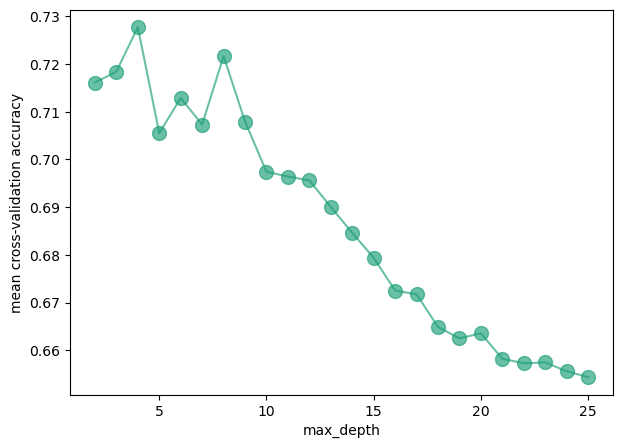

In [67]:
plt.figure(figsize=(7,5))
plt.plot(depth_values, cv_scores, '-o',markersize=10,alpha=0.65,color='#1b9e77') # using matplotlib.pyplot
plt.xlabel('max_depth')
plt.ylabel('mean cross-validation accuracy')
plt.show()

We can observe: A `max_depth` of 4 leads to the best mean accuracy. Bigger trees of more levels don't necessarily gain higher classification accuracy. They also tend to <b>overfit</b> the training data, resulting in the worsening performance we see here on the testing data, i.e. future new unseen data.

### 2.3 Neural Networks

**Train a neural network on the data**

`MLPClassifier` from `scikit-learn` implements multi-layer ANNs. Hyperparameter `hidden_layer_sizes` defines the number of neurons in each hidden layer, see more information in this [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). The training terminates after `max_iter` epochs, if it has not already converged (i.e. when there has been no improvement for a certain number of epochs). It does not mean that the ANN has perfectly learnt the training data.

In [68]:
# defines a multi-layer ANN with two hidden layers, of 4 neurons and 3 neurons, respectively
# you may observe that larger ANNs requires longer time to train!
mlp = MLPClassifier(hidden_layer_sizes=(4,3), max_iter=1000,random_state=1) # MLPClassifier uses some randomness too!
mlp.fit(X_train, y_train) 

MLPClassifier(hidden_layer_sizes=(4, 3), max_iter=1000, random_state=1)

**Evaluate the neural network's performance**

In [69]:
y_predict = mlp.predict(X_test) # use the trained network to predict labels for the test data
# calculate the accuracy: compare the true labels (y_test) with the predicted labels (y_predict)
print('Testing accuracy: \t', metrics.accuracy_score(y_test, y_predict))

Testing accuracy: 	 0.787112492648912


The accuracy of ANN 78% is slightly higher than the decision tree of 74%. How about the confusion matrix?

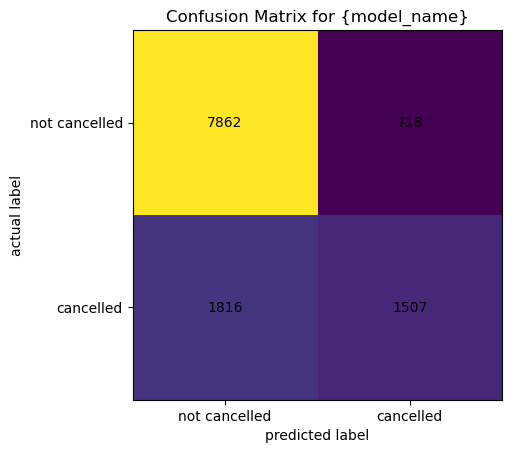

In [70]:
cm_mlp = metrics.confusion_matrix(y_test,y_predict) # calculate confusion matrix for the neural network
cf_matrix(cm_mlp,['not cancelled','cancelled'],'MLPClassifier') # plot the confusion matrix

We can observe: The confusion matrix shows that the <b>True Negatives</b> (correct classification of bookings not cancelled) of ANN is 7858, i.e. accuracy of 7858/(7858+722) = 91.6%, slightly worse than 99.8% from the decision tree. However, the ANN is much better at classifying cancellations - 1803/(1803+1520) = 54%, compared to 8% by the decision tree.

<b>Question</b>: Has our ANN overfit the training data?<br>
We can identify overfitting by checking if the accuracy of the model on the training data (known data) is much higher than that on the test data (unseen data). We already made predictions on the test data above, i.e. `y_predict`. We now compare it with the accuracy of our trained model on the training data.

In [71]:
y_predict_train = mlp.predict(X_train) # use our trained network to predict labels for the training data

# calculate the accuracies for both training and testing data
print('Training accuracy: \t', metrics.accuracy_score(y_train, y_predict_train))
print('Testing accuracy: \t', metrics.accuracy_score(y_test, y_predict)) 

Training accuracy: 	 0.785791444620481
Testing accuracy: 	 0.787112492648912


The accuracy on the training data is very similar to that on the testing data - the ANN has not overfit! This dataset is big enough, and our ANN simple enough. We are able to generalise well to new unseen future data!

<b>Question</b>: Which of the decision tree and ANN models is better?<br>
In terms of classification accuracy, ANN is much better, handling umbalanced samples well and achieving higher overall accuracy. ANN does require longer training time. For this small problem ANN beat the decision tree with a much higher accuracy at a reasonable training cost. In practice when the task is much larger and complex, training the AI models may lead to million dollar costs!

<a id='s3_task'></a>
<div class="alert alert-info">
    <h3>Task 2: machine learning models for the City Hotel</h3>
</div>

With the following steps, your task is now to build machine learning models to predict cancellations for the City Hotel. 

First, select the rows of the City Hotel from the original dataframe, and drop the irrelevant `hotel_` columns.

In [75]:
## your code here
city_df = df[df["hotel_City Hotel"] == 1]
city_df = city_df.drop(["hotel_City Hotel","hotel_Resort Hotel"],axis=1)

In [134]:
city_df[city_df["is_canceled"] == 1].describe()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,adr,required_car_parking_spaces,...,distribution_channel_TA/TO,distribution_channel_Undefined,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_quarter_Q1,arrival_quarter_Q2,arrival_quarter_Q3,arrival_quarter_Q4
count,33078.000000,33078.000000,33078.000000,33078.000000,33078.000000,33078.000000,33078.000000,33078.000000,33078.000000,33078.0,...,33078.000000,33078.000000,33078.000000,33078.000000,33078.000000,33078.000000,33078.000000,33078.000000,33078.000000,33078.000000
mean,0.212100,0.041478,0.045368,0.034248,0.026503,0.013302,0.006218,0.000362,0.200784,0.0,...,0.938176,0.000121,0.030232,0.000756,0.833908,0.135105,0.174104,0.321603,0.302769,0.201524
std,0.175027,0.048258,0.030523,0.008479,0.117169,0.114566,0.018992,0.010334,0.073689,0.0,...,0.240838,0.010996,0.171226,0.027482,0.372169,0.341841,0.379204,0.467099,0.459463,0.401144
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.070522,0.000000,0.020000,0.036364,0.000000,0.000000,0.000000,0.000000,0.147059,0.0,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.162200,0.052632,0.040000,0.036364,0.000000,0.000000,0.000000,0.000000,0.188824,0.0,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.318759,0.105263,0.060000,0.036364,0.000000,0.000000,0.000000,0.000000,0.241765,0.0,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,0.887165,0.526316,0.480000,0.072727,1.000000,1.000000,0.807692,0.805556,0.691176,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 3.1 Split the data into training and test sets

Remember to set the `random_state` parameter so your results are the same when you re-run your code!

In [77]:
## your code here
y = city_df["is_canceled"]
X = city_df.drop(["is_canceled"],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=True)

#### 3.2 Train a decision tree

Train a decision tree to predict cancellations at the City Hotel. You are encouraged to explore the above parameters and the others in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

Note: This is a relatively complex dataset. It can be difficult to improve the accuracies even with the hyperparameter tuning :) 

Testing accuracy: 	 0.7706329113924051


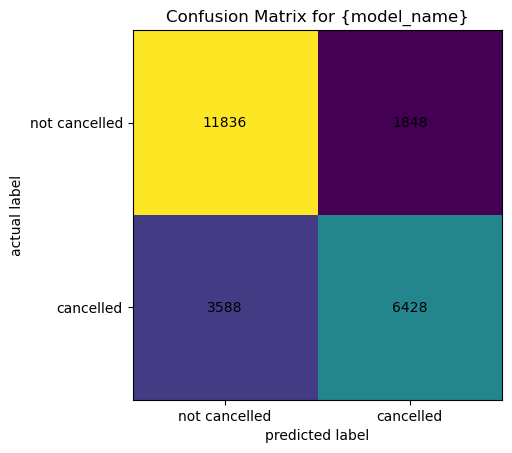

In [157]:
## your code for hyperparameter tuning here
city_tree = DecisionTreeClassifier(max_depth=5,random_state=1,)
city_tree.fit(X_train,y_train)

y_predict = city_tree.predict(X_test)

print('Testing accuracy: \t', metrics.accuracy_score(y_test, y_predict))

cm_mlp = metrics.confusion_matrix(y_test,y_predict) # calculate confusion matrix for the neural network
cf_matrix(cm_mlp,['not cancelled','cancelled'],'Custom Tree Classifier')

Once you are happy with the hyperparameter settings, save the best decision tree classifier to a variable called `tree_final`. We will use this later to compare performance with a neural network.

In [154]:
## your code here
tree_final = DecisionTreeClassifier(max_depth=5,random_state=1)
tree_final.fit


<bound method DecisionTreeClassifier.fit of DecisionTreeClassifier(max_depth=4, random_state=1)>

#### 3.3 Train a neural network

Similarly, train a ANN to predict cancellations at the City Hotel. More hyperparameter settings, e.g. different architectures, can be found here ([scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)).

Note: Some hyperparameter combinations in the ANNs may take several minutes to train!

Testing accuracy: 	 0.7819831223628692


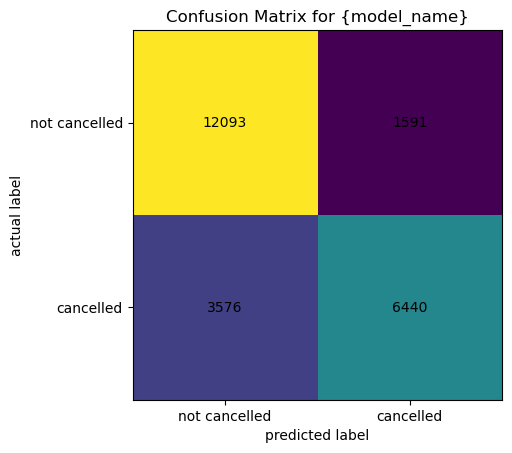

In [173]:
## your code for hyperparameter tuning here
N_city = MLPClassifier(hidden_layer_sizes=(7,3),max_iter=1000,random_state=1)
N_city.fit(X_train,y_train)

y_predict = N_city.predict(X_test)

print('Testing accuracy: \t', metrics.accuracy_score(y_test, y_predict))

cm_mlp = metrics.confusion_matrix(y_test,y_predict) # calculate confusion matrix for the neural network
cf_matrix(cm_mlp,['not cancelled','cancelled'],'Custom Tree Classifier')

Save your best MLP classifier to a variable called `mlp_final`. We will next compare the decision tree and ANN.

In [ ]:
## your code here
mlp_final = MLPClassifier(hidden_layer_sizes=(7,3),max_iter=1000,random_state=1)
mlp_final.fit ...


#### 3.4 Compare the performance of your models

For each model, predict the labels for the test set, and then calculate and print the accuracy.

In [171]:
## your code here
y_predict = N_city.predict(X_test)

print('Testing accuracy Neural Network: \t', metrics.accuracy_score(y_test, y_predict))

y_predict = city_tree.predict(X_test)

print('Testing accuracy Tree Model: \t', metrics.accuracy_score(y_test, y_predict))

Testing accuracy Neural Network: 	 0.7819831223628692
Testing accuracy Tree Model: 	 0.7706329113924051


Have either of your models overfit the training data? Use an appropriate method to check.

In [177]:
## your code here
y_train_pred = N_city.predict(X_train)
y_pred = N_city.predict(X_test)

print("Nural Network:\n")
print("Training prediction:", metrics.accuracy_score(y_train,y_train_pred),"\n")
print("Testing prediction:", metrics.accuracy_score(y_test,y_pred),"\n")

y_train_pred = city_tree.predict(X_train)
y_pred = city_tree.predict(X_test)

print("Tree Clasifier:\n")
print("Training prediction:", metrics.accuracy_score(y_train,y_train_pred),"\n")
print("Testing prediction:", metrics.accuracy_score(y_test,y_pred),"\n")


Nural Network:

Training prediction: 0.7852544395819017 

Testing prediction: 0.7819831223628692 

Tree Clasifier:

Training prediction: 0.7714022206951426 

Testing prediction: 0.7706329113924051 



Plot the confusion matrices for both models. Is either model better at **predicting cancellations** than the other?

In [ ]:
## your code here to calculate the confusion matrices


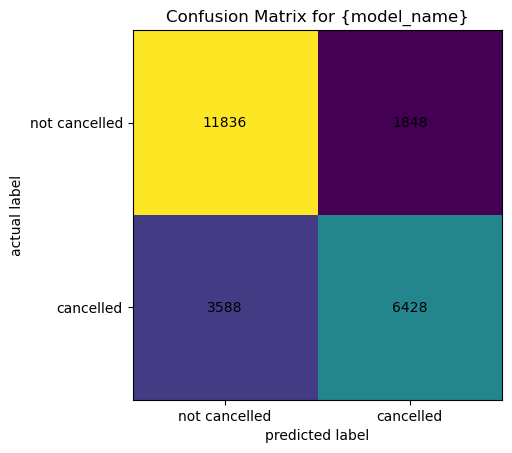

In [188]:
## your code here to plot the confusion matrix for the decision tree
y_pred = city_tree.predict(X_test)

cm_mlp = metrics.confusion_matrix(y_test,y_pred) # calculate confusion matrix for the neural network
cf_matrix(cm_mlp,['not cancelled','cancelled'],'Custom Tree Classifier')

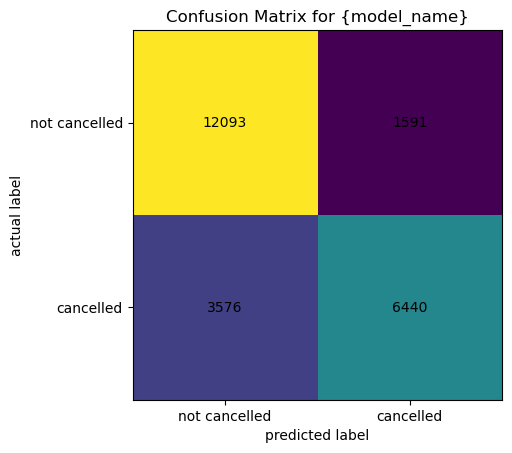

In [186]:
## your code here to plot the confusion matrix for the neural network
y_pred = N_city.predict(X_test)

cm_mlp = metrics.confusion_matrix(y_test,y_pred) # calculate confusion matrix for the neural network
cf_matrix(cm_mlp,['not cancelled','cancelled'],'Custom Neural Network')

<b>Question:</b> It's likely that your decision tree is more successful at classifying cancellations for the City Hotel than for the Resort Hotel. Why might this be?

This is because there is more samples in city hotel that have been canceled, as denoted previously the percentage of cancelations was higher for city hotel than resort hotel.

Finally, visualise your decision tree using the `plot_tree()` function. Use this figure to identify:

+ The most important features for predicting cancellations at the City Hotel. Are they different to those for the Resort Hotel? 
+ Some of the rules the decision tree produces

Note: Your tree will only display properly, and be readable, if it is relatively simple. If it's not, you may want to train a smaller decision tree :) 

[Text(0.5270833333333333, 0.9166666666666666, 'total_of_special_requests <= 0.1\ngini = 0.486\nsamples = 55298\nvalue = [32236, 23062]\nclass = Not Cancelled'),
 Text(0.26666666666666666, 0.75, 'lead_time <= 0.035\ngini = 0.495\nsamples = 33328\nvalue = [14965, 18363]\nclass = Cancelled'),
 Text(0.13333333333333333, 0.5833333333333334, 'lead_time <= 0.011\ngini = 0.374\nsamples = 7701\nvalue = [5786, 1915]\nclass = Not Cancelled'),
 Text(0.06666666666666667, 0.4166666666666667, 'previous_cancellations <= 0.019\ngini = 0.269\nsamples = 4265\nvalue = [3582, 683]\nclass = Not Cancelled'),
 Text(0.03333333333333333, 0.25, 'lead_time <= 0.001\ngini = 0.256\nsamples = 4136\nvalue = [3512, 624]\nclass = Not Cancelled'),
 Text(0.016666666666666666, 0.08333333333333333, 'gini = 0.182\nsamples = 1429\nvalue = [1284, 145]\nclass = Not Cancelled'),
 Text(0.05, 0.08333333333333333, 'gini = 0.291\nsamples = 2707\nvalue = [2228, 479]\nclass = Not Cancelled'),
 Text(0.1, 0.25, 'previous_bookings_not_c

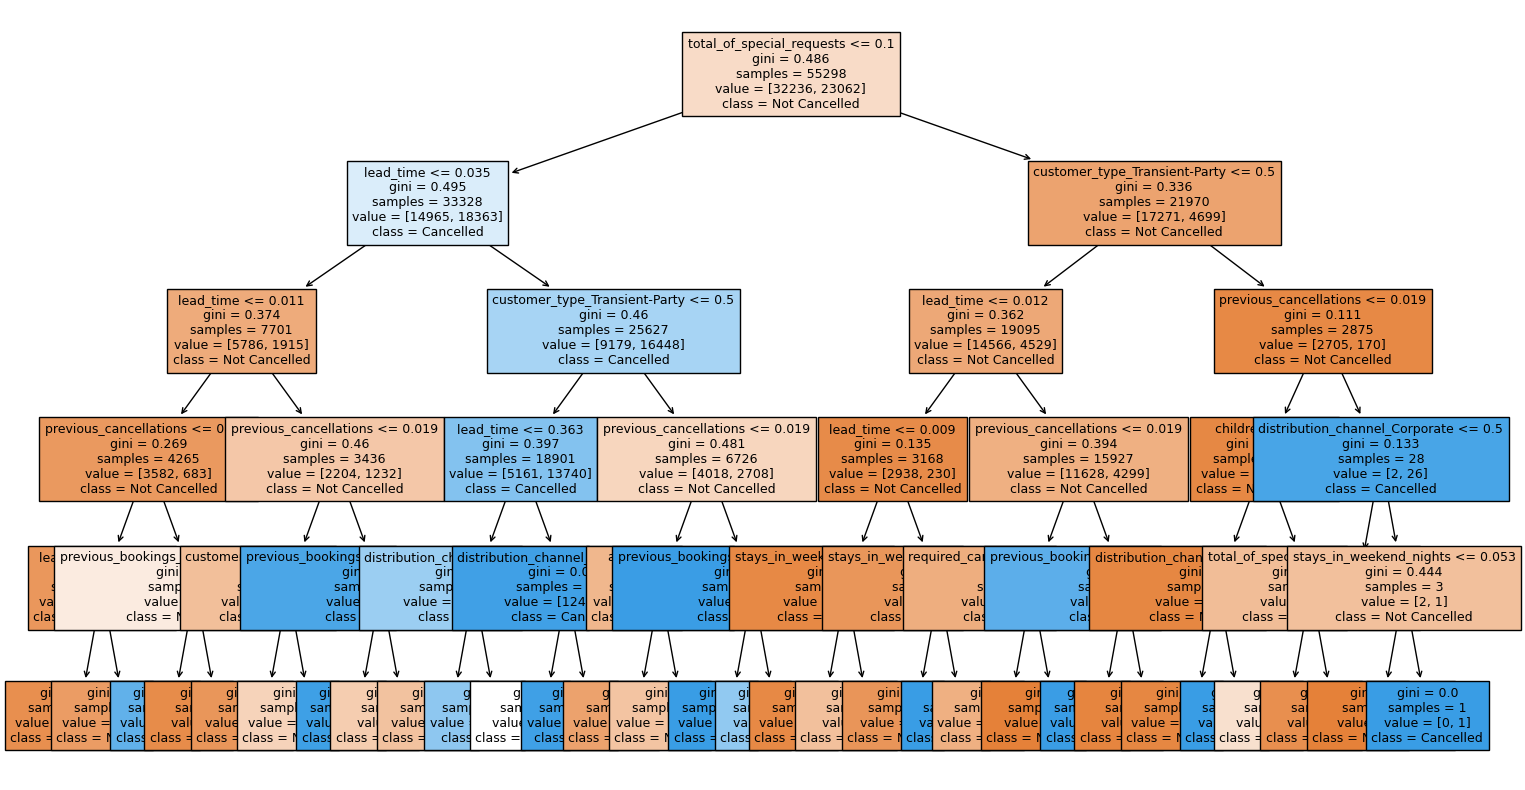

In [189]:
## your code here
hotel_features = list(X_train.columns)
hotel_class = ['Not Cancelled','Cancelled'] # Not Cancelled = 0, Cancelled = 1

plt.figure(figsize=(18,10)) # You may need to adjust this value to get the tree to fit on your screen
plot_tree(city_tree, feature_names = hotel_features, class_names=hotel_class, filled=True, fontsize=9)


<hr style="border: 3px solid green;"/>

This is the last COMP1008 computing exercise. The remainder computing sessions before the Easter break are for completing your coursework. If you have questions about any of the computing exercises or the coursework, please either come to the computing support sessions, or ask in the Teams channel.

<div class="alert alert-success">
    <h2>🍰 End</h2> 
</div>